In [2]:
from google.colab import files
import pandas as pd

# This will open a file picker
uploaded = files.upload()

# After uploading, load the CSV
df = pd.read_csv("train.csv")
print(df.shape)
print(df.head())



Saving train.csv to train.csv
(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCon

Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Target
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

# Separate numeric and categorical
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Transformers
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


Train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Baseline models + Regularization

In [15]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import numpy as np # Import numpy for sqrt function

# Linear Regression
linreg = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

# Lasso Regression (L1)
lasso = Pipeline([
    ('pre', preprocessor),
    ('reg', Lasso(alpha=0.01, max_iter=20000)) # Increased max_iter further
])
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("LASSO RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R2:", r2_score(y_test, y_pred_lasso))

# Ridge Regression (L2)
ridge = Pipeline([
    ('pre', preprocessor),
    ('reg', Ridge(alpha=1.0, max_iter=5000))
])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R2:", r2_score(y_test, y_pred_ridge))

Linear Regression RMSE: 29476.18461645959
R2: 0.8867264004066089
LASSO RMSE: 28375.910855215447
R2: 0.895025023041567
Ridge RMSE: 29844.251463164233
R2: 0.8838798609944372


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94380499648.94275, tolerance: 696659484.3571944
  model = cd_fast.sparse_enet_coordinate_descent(


Feature Selection / Importance

For tree-based approach:

OverallQual         0.554295
GrLivArea           0.122653
TotalBsmtSF         0.032908
2ndFlrSF            0.030620
1stFlrSF            0.027188
BsmtFinSF1          0.026883
LotArea             0.017378
GarageArea          0.015469
GarageCars          0.013934
YearBuilt           0.012016
LotFrontage         0.008865
YearRemodAdd        0.006826
BsmtQual_Ex         0.006602
FullBath            0.006045
GarageYrBlt         0.006026
GarageFinish_Unf    0.006002
TotRmsAbvGrd        0.005901
OpenPorchSF         0.005142
BsmtUnfSF           0.004794
WoodDeckSF          0.004259
dtype: float64


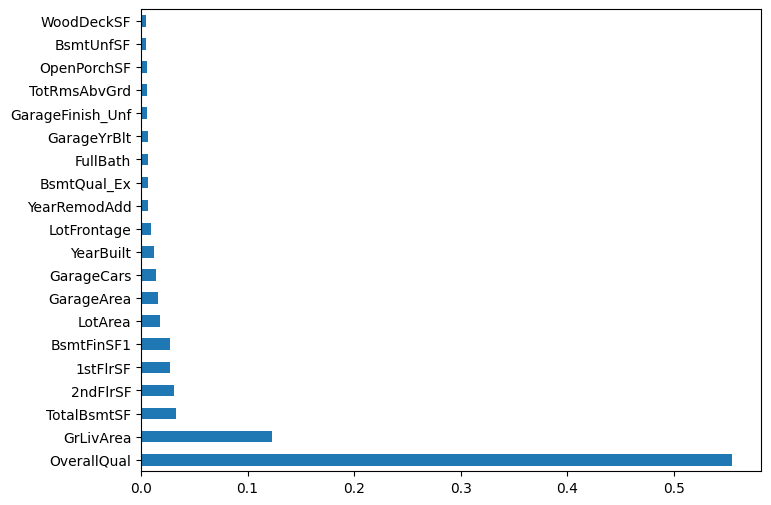

In [8]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

rf = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)

# Feature importances
X_pre = preprocessor.transform(X_train)
importances = rf.named_steps['rf'].feature_importances_
feature_names = num_cols + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols))
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(20))
feat_imp.head(20).plot(kind='barh', figsize=(8,6))
plt.show()


SHAP Interpretation

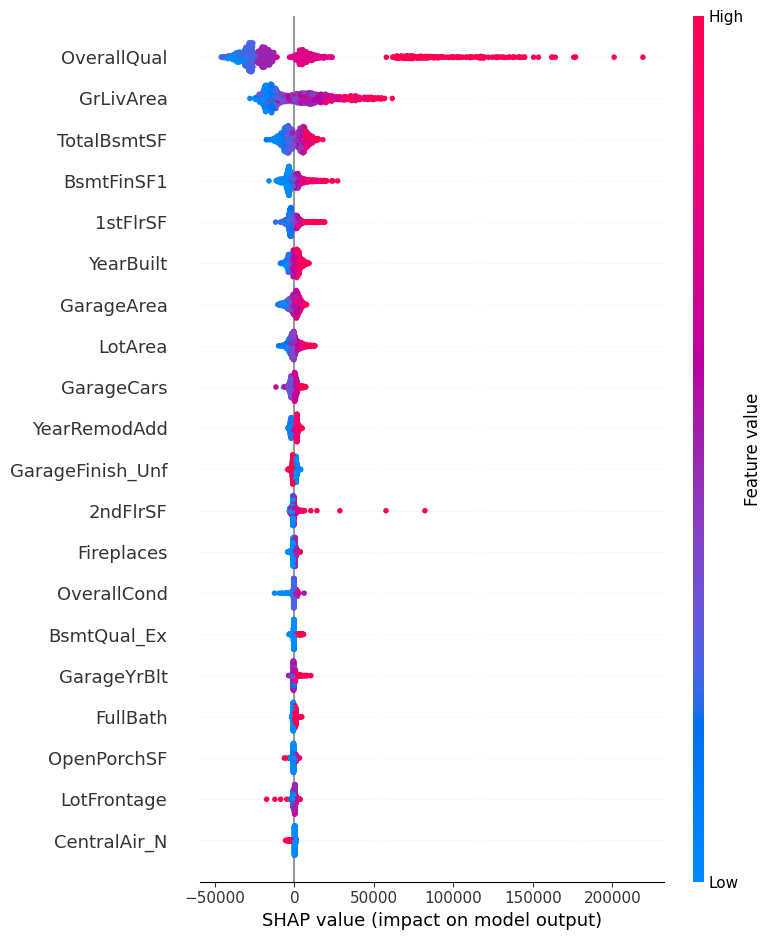

In [12]:
import shap
import numpy as np # Ensure numpy is imported

explainer = shap.TreeExplainer(rf.named_steps['rf'])

# Ensure X_pre is a dense NumPy array with a numeric dtype
# ColumnTransformer with OneHotEncoder can produce sparse matrices.
# shap.TreeExplainer expects dense input for np.isnan check.
if hasattr(X_pre, 'toarray'):
    X_pre_dense = X_pre.toarray()
else:
    X_pre_dense = X_pre

# Convert to float64 to ensure consistent numeric type, handling any potential 'object' dtype issues.
# The error suggests 'O' (object) dtype, so explicitly casting to a numeric type is important.
X_pre_dense = X_pre_dense.astype(np.float64)

shap_values = explainer.shap_values(X_pre_dense)

# Global importance
# Pass the dense, float-typed array to summary_plot as well.
shap.summary_plot(shap_values, X_pre_dense, feature_names=feature_names)


In [17]:
# Install Streamlit
!pip install streamlit


In [18]:
# Save the trained Random Forest model
import joblib
joblib.dump(rf, "house_price_model.pkl")
print("Model saved as house_price_model.pkl")

Model saved as house_price_model.pkl


Build a Streamlit Web App

In [20]:
# Install Streamlit (ensure it's available for this cell)
!pip install streamlit

import streamlit as st
import pandas as pd
import joblib

# Load trained model (pre-trained pipeline)
model = joblib.load("house_price_model.pkl")

st.title("House Price Prediction")

# Input fields
lotarea = st.number_input("Lot Area", min_value=100, max_value=100000, value=5000)
overallqual = st.slider("Overall Quality", 1, 10, 5)
yearbuilt = st.number_input("Year Built", min_value=1800, max_value=2025, value=2000)
# Add more inputs as needed

# Create dataframe
input_df = pd.DataFrame({
    'LotArea':[lotarea],
    'OverallQual':[overallqual],
    'YearBuilt':[yearbuilt]
})

# Predict
if st.button("Predict Price"):
    price = model.predict(input_df)[0]
    st.success(f"Estimated House Price: ${price:,.2f}")

2025-11-21 21:13:09.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.156 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.159 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.160 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.161 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-21 21:13:09.162 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

streamlit run app.py


In [25]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load trained model (pre-trained pipeline)
model = joblib.load("house_price_model.pkl")

st.title("House Price Prediction")

# Input fields
lotarea = st.number_input("Lot Area", min_value=100, max_value=100000, value=5000)
overallqual = st.slider("Overall Quality", 1, 10, 5)
yearbuilt = st.number_input("Year Built", min_value=1800, max_value=2025, value=2000)
# Add more inputs as needed

# Create dataframe
input_df = pd.DataFrame({
    'LotArea':[lotarea],
    'OverallQual':[overallqual],
    'YearBuilt':[yearbuilt]
})

# Predict
if st.button("Predict Price"):
    price = model.predict(input_df)[0]
    st.success(f"Estimated House Price: ${price:,.2f}")

!streamlit run app.py


Overwriting app.py
